In [1]:
#importing libraries and packages
import sys,os,time
print(sys.executable)
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
#import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.markers
from pandas.tseries.frequencies import to_offset# needed to set the time offset to match to the muons DF
import seaborn as sns
from numpy import argmax
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#import pylab as plt
#import ROOT

/usr/bin/python3


2024-07-23 10:31:27.638744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-23 10:31:27.638768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#%matplotlib widget
from ipywidgets import interactive
%matplotlib inline

In [3]:
from __future__ import print_function
import json
import time
#import datetime import datetime, timedelta
#from datetime import datetime, timedelta
#import pandas as pd

# Python 2 and 3: alternative 4
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM
    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.
    Args:
      uri (string): URL to fetch
    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist(filename):
    """Build a listing of stations from a simple file listing the stations.
    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = []
    states = "CA"
    # IEM quirk to have Iowa AWOS sites in its own labeled network
    networks = ["ASOS"]
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/" "geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append(site["properties"]["sid"])
    return stations

def main():
    """Our main method"""
    # timestamps in UTC to request data for
    startts = datetime(2022, 6, 23)
    #endts = datetime.datetime(2022, 7, 25)
    #startts = datetime.utcnow().date() - timedelta(days=1095)#datetime.datetime(2020, 6, 15)
    endts   = datetime.utcnow().date()
    
    #service = SERVICE + "data=mslp&=Etc/UTC&format=comma&=yes&"

    #service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
    #service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()
    stations = ['BUR']
    print(stations)
    print(type(stations))
    # stations = get_stations_from_filelist("mystations.txt")
    #print(service)
    
    dfs = []
    
    data_types = ["mslp", "tmpf"]
    for station in stations:
        
        for data_type in data_types:
            
            service = SERVICE + "data="+data_type+"&=Etc/UTC&format=onlytdf&=yes&"

            service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
            service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

            uri = "%s&station=%s" % (service, station)
            print("Downloading: %s - %s" % (station, data_type))
            data = download_data(uri)
            outfn = "%s_%s_%s.txt" % (
                station,
                startts.strftime("%Y%m%d%H%M"),
                endts.strftime("%Y%m%d%H%M"),
            )
            out = open(outfn, "w")
            out.write(data)
            
            df = pd.read_csv(outfn, sep='\t' )
            out.close()
            dfs.append(df)
        
            df.head()
            print(df)
    
    final_dataframe = pd.merge(dfs[0], dfs[1])
    print(final_dataframe)
    final_dataframe.to_csv("mslp_temp_Chara.csv",index = False)

if __name__ == "__main__":
    main()

['BUR']
<class 'list'>
Downloading: BUR - mslp
       station             valid     mslp
0          BUR  2022-06-23 00:00        M
1          BUR  2022-06-23 00:05        M
2          BUR  2022-06-23 00:10        M
3          BUR  2022-06-23 00:15        M
4          BUR  2022-06-23 00:20        M
...        ...               ...      ...
236717     BUR  2024-07-22 23:40        M
236718     BUR  2024-07-22 23:45        M
236719     BUR  2024-07-22 23:50        M
236720     BUR  2024-07-22 23:53  1007.60
236721     BUR  2024-07-22 23:55        M

[236722 rows x 3 columns]
Downloading: BUR - tmpf
       station             valid   tmpf
0          BUR  2022-06-23 00:00      M
1          BUR  2022-06-23 00:05      M
2          BUR  2022-06-23 00:10      M
3          BUR  2022-06-23 00:15      M
4          BUR  2022-06-23 00:20      M
...        ...               ...    ...
236717     BUR  2024-07-22 23:40      M
236718     BUR  2024-07-22 23:45      M
236719     BUR  2024-07-22 23:50      

In [4]:
def merge_tables(df1, dfpt):
    # Ensure index is datetime type
    df1.index = pd.to_datetime(df1.index)
    dfpt.index = pd.to_datetime(dfpt.index)
    
    # Sort DataFrames by index
    df1.sort_index(inplace=True)
    dfpt.sort_index(inplace=True)
    
    # Merge DataFrames using inner join
    merged_tab = pd.merge(df1, dfpt, how='inner', left_index=True, right_index=True)
    
    return merged_tab


In [5]:
def calc_percent_change(merged_df):
    merged_df["Ch12_pct"] = ((merged_df['Ch12'] - merged_df['Ch12'].mean())/ 
                      merged_df['Ch12'].mean()*100)
    merged_df["Ch13_pct"] = ((merged_df['Ch13'] - merged_df['Ch13'].mean())/ 
                      merged_df['Ch13'].mean()*100)
    merged_df["Ch23_pct"] = ((merged_df['Ch23'] - merged_df['Ch23'].mean())/ 
                      merged_df['Ch23'].mean()*100)
    merged_df["Ch12_m_avg"] = merged_df.rolling('6H').Ch12_pct.mean()
    merged_df["Ch13_m_avg"] = merged_df.rolling('6H').Ch13_pct.mean()
    merged_df["Ch23_m_avg"] = merged_df.rolling('6H').Ch23_pct.mean()
    merged_df["press_pct"] = 2*((merged_df['mslp'] - merged_df['mslp'].mean())/ 
                      merged_df['mslp'].mean()*100)
    merged_df["temp_pct"] = ((merged_df['tmpf'] - merged_df['tmpf'].mean())/ 
                      merged_df['tmpf'].mean()*100)
    merged_df['temp_scaled'] = 0.1*merged_df['temp_pct']
    merged_df["delta_Ch12"]  = np.log((merged_df["Ch12"])/merged_df["Ch12"].mean())
    merged_df["delta_Ch13"]  = np.log((merged_df["Ch13"])/merged_df["Ch13"].mean())
    merged_df["delta_Ch23"]  = np.log((merged_df["Ch23"])/merged_df["Ch23"].mean())
    merged_df["delta_pres"] = (merged_df["mslp"]-merged_df["mslp"].mean())
    print(merged_df["mslp"].mean(),merged_df["mslp"].std(), merged_df['Ch12_pct'].max()*1.2, merged_df["Ch12"].mean(),merged_df["Ch12_pct"].std())
    

In [6]:
#pd.Timestamp('2019-10-21T12:05:04.126Z')
dtypes = {'date': 'Timestamp'}

fname1 = '/home/cosmic/onlineMon/data/Muon002/2022-06-24T02h11m33s371Z.log'
fname2 = '/home/cosmic/onlineMon/data/Muon002/2023-02-27T02h23m37s700Z.log'
fname4 = '/home/cosmic/onlineMon/data/Muon002/2023-08-24T18.log'
fname5 = '/home/cosmic/onlineMon/data/Muon002/2024-01-04T23h30m32s612Z.log'
fname6 = '/home/cosmic/onlineMon/data/Muon002/2024-02-23T15h46m58s213Z.log'
fname3 = '/home/cosmic/onlineMon/data/Muon002/Muon002_CHARA.log'



#df1  = pd.read_csv(fname1,index_col="date",parse_dates=['date'])

df_1 = pd.read_csv(fname1,index_col="date",parse_dates=['date'])
df_2 = pd.read_csv(fname2,index_col="date",parse_dates=['date'])
df_4 = pd.read_csv(fname4,index_col="date",parse_dates=['date'])
df_5 = pd.read_csv(fname5,index_col="date",parse_dates=['date'])
df_6 = pd.read_csv(fname6,index_col="date",parse_dates=['date'])
df_3 = pd.read_csv(fname3,index_col="date",parse_dates=['date'])


frames = [df_1, df_2, df_4, df_5, df_6, df_3]
df1  = pd.concat(frames)

df1.rename(columns = {'One and Three':'Ch13', 'One and Two':'Ch12', 'Two and Three':'Ch23'},inplace = True)
df1.drop(df1.columns[[0,1,2,6,10]],axis=1, inplace=True)
#df1 = df1.drop(columns=["One","Two","Three"])
df1

,Ch12,Ch13,Ch23,One,Two,Three
date,,,,,,
2022-06-24 02:12:33.423000+00:00,349.0,180.0,343.0,1200.0,1160.0,1107.0
2022-06-24 02:13:33.426000+00:00,341.0,171.0,334.0,1182.0,1118.0,1098.0
2022-06-24 02:14:33.428000+00:00,331.0,185.0,356.0,1198.0,1145.0,1116.0
2022-06-24 02:15:33.430000+00:00,314.0,165.0,307.0,1175.0,1077.0,1113.0
2022-06-24 02:16:33.431000+00:00,323.0,182.0,363.0,1127.0,1137.0,1157.0
...,...,...,...,...,...,...
2024-07-23 14:17:31.607000+00:00,288.0,140.0,310.0,1123.0,1038.0,1095.0
2024-07-23 14:18:31.608000+00:00,331.0,172.0,349.0,1129.0,1138.0,1134.0
2024-07-23 14:19:31.609000+00:00,293.0,151.0,307.0,1151.0,1055.0,1063.0


In [7]:
#df1.index=pd.to_datetime(df1.index)
#import pytz
#df1.index=(df1.index).tz_localize(None)
df1.shape

(1027176, 6)

In [8]:
df1.info
#df1

<bound method DataFrame.info of                                    Ch12   Ch13   Ch23     One     Two   Three
date                                                                         
2022-06-24 02:12:33.423000+00:00  349.0  180.0  343.0  1200.0  1160.0  1107.0
2022-06-24 02:13:33.426000+00:00  341.0  171.0  334.0  1182.0  1118.0  1098.0
2022-06-24 02:14:33.428000+00:00  331.0  185.0  356.0  1198.0  1145.0  1116.0
2022-06-24 02:15:33.430000+00:00  314.0  165.0  307.0  1175.0  1077.0  1113.0
2022-06-24 02:16:33.431000+00:00  323.0  182.0  363.0  1127.0  1137.0  1157.0
...                                 ...    ...    ...     ...     ...     ...
2024-07-23 14:17:31.607000+00:00  288.0  140.0  310.0  1123.0  1038.0  1095.0
2024-07-23 14:18:31.608000+00:00  331.0  172.0  349.0  1129.0  1138.0  1134.0
2024-07-23 14:19:31.609000+00:00  293.0  151.0  307.0  1151.0  1055.0  1063.0
2024-07-23 14:20:31.610000+00:00  319.0  171.0  349.0  1100.0  1133.0  1092.0
2024-07-23 14:21:31.610000+00:00

In [9]:
df1_hourly = df1.resample('H').sum()
df1_hourly.drop(df1_hourly.head(1).index,inplace=True)
df1_hourly.drop(df1_hourly.tail(1).index,inplace=True)
#df1_hourly.drop(df1_hourly[df1_hourly['Ch12'] < 7000].index, inplace = True)
pd.to_datetime(df1_hourly.index).hour
pd.to_datetime(df1_hourly.index).hour
df1_hourly.head(10)
df1_hourly
#df1_hourly[df1_hourly['Ch12'] <7000]

,Ch12,Ch13,Ch23,One,Two,Three
date,,,,,,
2022-06-24 03:00:00+00:00,19564.0,10121.0,20360.0,71070.0,67416.0,67584.0
2022-06-24 04:00:00+00:00,19499.0,10149.0,20460.0,70850.0,67312.0,68018.0
2022-06-24 05:00:00+00:00,19230.0,9870.0,20169.0,70791.0,66719.0,67283.0
2022-06-24 06:00:00+00:00,19763.0,10296.0,20388.0,71471.0,67587.0,67833.0
2022-06-24 07:00:00+00:00,19555.0,10161.0,20375.0,71477.0,67795.0,68201.0
...,...,...,...,...,...,...
2024-07-23 09:00:00+00:00,19108.0,9819.0,19784.0,68887.0,65087.0,63512.0
2024-07-23 10:00:00+00:00,18776.0,9672.0,19558.0,68095.0,64580.0,63792.0
2024-07-23 11:00:00+00:00,19192.0,9967.0,19871.0,69196.0,64946.0,63913.0


In [10]:
fPT1    ='mslp_temp_Chara.csv'
df1_PT  = pd.read_csv(fPT1)
df1_PT.drop(df1_PT[df1_PT['mslp'] == 'M'].index, inplace = True)
df1_PT.drop(df1_PT[df1_PT['tmpf'] == 'M'].index, inplace = True)
df1_PT.dropna(inplace=True)
df1_PT['valid'] = pd.to_datetime(df1_PT['valid'], utc =True)
df1_PT = df1_PT.set_index('valid')
df1_PT = df1_PT.drop(columns=["station"])
loffset = '-53min'
df1_PT.index = df1_PT.index + to_offset(loffset)
df1_PT["mslp"] = df1_PT["mslp"].astype(str).astype(float)
df1_PT["tmpf"] = df1_PT["tmpf"].astype(str).astype(float)
df1_PT.tail(10)

,mslp,tmpf
valid,,
2024-07-22 14:00:00+00:00,1010.5,75.0
2024-07-22 15:00:00+00:00,1010.5,79.0
2024-07-22 16:00:00+00:00,1010.1,84.0
2024-07-22 17:00:00+00:00,1009.9,88.0
2024-07-22 18:00:00+00:00,1009.8,90.0
2024-07-22 19:00:00+00:00,1009.5,90.0
2024-07-22 20:00:00+00:00,1009.0,93.0
2024-07-22 21:00:00+00:00,1008.5,93.0
2024-07-22 22:00:00+00:00,1007.9,92.0


In [11]:
#merged_df1=pd.merge(df1_hourly,df1_PT, how='inner', left_index=True, right_index=True)
#merged_df1
merged_df1= merge_tables(df1_hourly,df1_PT)
merged_df1.drop(merged_df1[merged_df1['Ch12']<10].index,inplace=True) 
merged_df1
#merged_df1[merged_df1['Ch12']<10]

,Ch12,Ch13,Ch23,One,Two,Three,mslp,tmpf
2022-06-24 03:00:00+00:00,19564.0,10121.0,20360.0,71070.0,67416.0,67584.0,1009.7,76.0
2022-06-24 04:00:00+00:00,19499.0,10149.0,20460.0,70850.0,67312.0,68018.0,1010.0,74.0
2022-06-24 05:00:00+00:00,19230.0,9870.0,20169.0,70791.0,66719.0,67283.0,1010.1,73.0
2022-06-24 06:00:00+00:00,19763.0,10296.0,20388.0,71471.0,67587.0,67833.0,1010.2,72.0
2022-06-24 07:00:00+00:00,19555.0,10161.0,20375.0,71477.0,67795.0,68201.0,1010.3,69.0
...,...,...,...,...,...,...,...,...
2024-07-22 19:00:00+00:00,19078.0,9900.0,19995.0,68577.0,65139.0,64123.0,1009.5,90.0
2024-07-22 20:00:00+00:00,18934.0,9797.0,19940.0,67991.0,64929.0,64060.0,1009.0,93.0
2024-07-22 21:00:00+00:00,18844.0,9617.0,19396.0,67959.0,64766.0,63694.0,1008.5,93.0
2024-07-22 22:00:00+00:00,18948.0,9696.0,19659.0,67593.0,65144.0,63686.0,1007.9,92.0


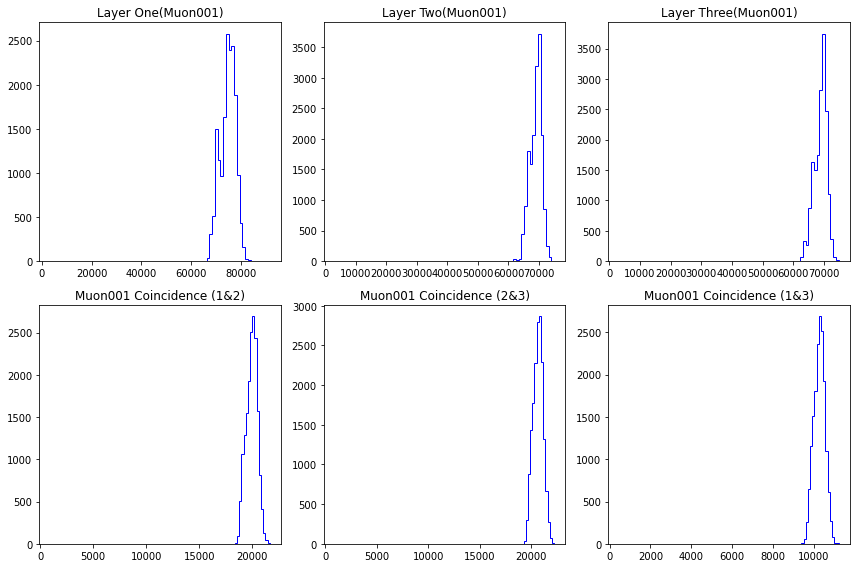

In [12]:
fig, axs = plt.subplots(2, 3, sharey=False, sharex=False,tight_layout=True,figsize=(12, 8))
#fig.suptitle('Muon001)')
axs[0,0].hist(merged_df1['One'], bins=80,histtype='step',label='One(Muon001)',color='blue')
axs[0,0].set_title("Layer One(Muon001)")
#axs[0,0].set_xlim(900,1400)
axs[0,1].hist(merged_df1['Two'], bins=80,histtype='step',label='Two(Muon001)',color='blue')
axs[0,1].set_title("Layer Two(Muon001)")
#axs[0,1].set_xlim(1000,1500)
axs[0,2].hist(merged_df1['Three'], bins=80,histtype='step',label='Three(Muon001)',color='blue')
axs[0,2].set_title("Layer Three(Muon001)")
#axs[0,2].set_xlim(900,1500)
axs[1,0].hist(merged_df1['Ch12'],histtype='step',bins=100,color='blue')
axs[1,0].set_title("Muon001 Coincidence (1&2)")
axs[1,1].hist(merged_df1['Ch23'],histtype='step',bins=100,color='blue')
axs[1,1].set_title("Muon001 Coincidence (2&3)")
axs[1,2].hist(merged_df1['Ch13'],histtype='step',bins=100,color='blue')
axs[1,2].set_title("Muon001 Coincidence (1&3)")

#axs[1,2].set_xlim(900,1500)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.legend(['Example legend'],loc='upper center')
plt.savefig('/home/cosmic/onlineMon/images/M002_ch_coinc_mostrecent.png')

In [13]:
merged_df1 = merged_df1.drop(columns=["One","Two","Three"])

In [14]:
from datetime import datetime, timedelta
now = datetime.utcnow().date()
yesterday = datetime.utcnow().date() - timedelta(days=1)
lastmonth = datetime.utcnow().date() - timedelta(days=30)
print(now)
print(yesterday)
print(lastmonth)
#mask = (merged_df1['date'] > yesterday) & (merged_df1['date'] <= now)
#merged_df1.loc[mask]
merged_df1_1day   = merged_df1.loc[yesterday:now].copy()
merged_df1_1day
merged_df1_31days =merged_df1.loc[lastmonth:now].copy()

#start_date = '2022-01-15'
#end_date ='2022-01-18'
#merged_df1_1day   = merged_df1.loc[start_date:end_date].copy()
#merged_df1_1day

2024-07-23
2024-07-22
2024-06-23


## Compute the %age change and rolling average

In [15]:
calc_percent_change(merged_df1_1day)
calc_percent_change(merged_df1_31days)
calc_percent_change(merged_df1)

1009.8166666666666 0.8800526993442963 1.9695831316275334 19021.791666666668 0.7655655659313397
1011.0629526462395 2.105029687818416 4.8835782251733 19038.211699164345 1.1572086359690974
1014.1591239591884 3.959840885843527 10.543253283505914 19926.269145068607 3.574239923723082


## Plot the %age change

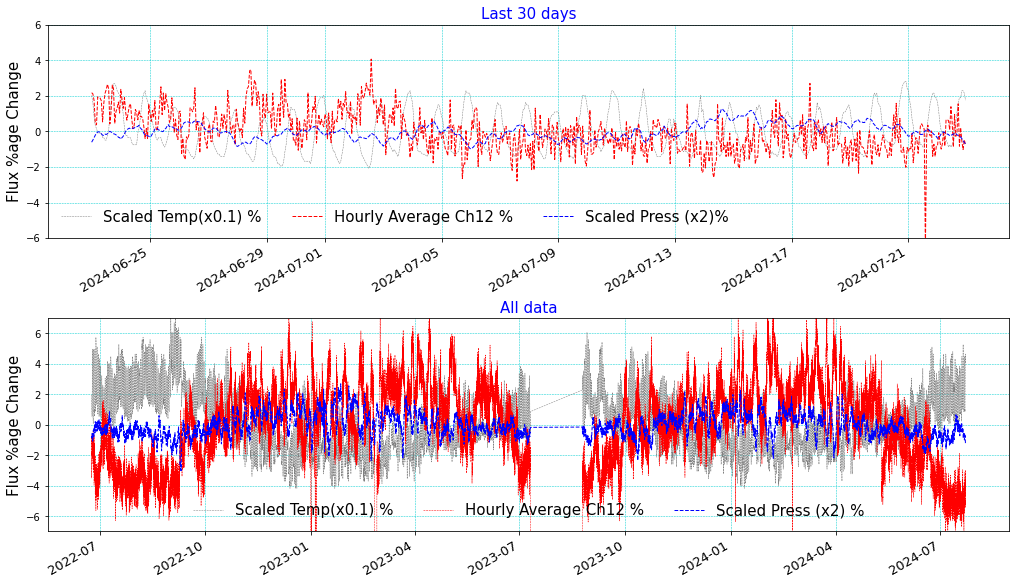

In [16]:
fig = plt.figure(figsize=(14, 8),constrained_layout=True)
gs = fig.add_gridspec(2)
axs = gs.subplots(sharex=False, sharey=False)
#fig.suptitle('Flux %age Change (Muon001 Detector)')
#axs[0].set_title("Last 24 hours (yesterday:now)")
#axs[0].set_title('Last 24 hours:'+str(now)+' to ' +str(yesterday),fontsize=15,color='blue')
#axs[0].plot(merged_df1_1day['temp_scaled']
#            , linestyle='--', linewidth=0.5, color='gray', label='scaled Temp(x0.1) %')
#axs[0].plot(merged_df1_1day['Ch12_m_avg'],
#            linestyle='--', linewidth=0.5, color='red', label='Rolling avg(24Hr)Ch12 %')
##axs[0].plot(merged_df1_1day["Ch13_m_avg"],
##            linestyle='--', linewidth=0.5, color='green', label="Rolling avg(6Hr)Ch13 %")
##axs[0].plot(merged_df1_1day["Ch23_m_avg"],
  # #         linestyle='--', linewidth=0.5, color='black', label="Rolling avg(6Hr)Ch23 %")
#axs[0].plot(merged_df1_1day['press_pct'],
#            linestyle='-', linewidth=0.5, color='blue', label='Press (x5)%')
##axs[0].plot(merged_df1["Ch12_m_avg"],
##            linestyle='--', linewidth=0.5, color='black', label="Rolling avg(6Hr)Ch23 %")

axs[0].set_title("Last 30 days",fontsize=15,color='blue')
axs[0].plot(merged_df1_31days['temp_scaled'],
            linestyle='--', linewidth=0.5, color='gray', label='Scaled Temp(x0.1) %')
axs[0].plot(merged_df1_31days['Ch12_pct'],
            linestyle='--', linewidth=1, color='red', label='Hourly Average Ch12 %')
#axs[1].plot(merged_df1_31days["Ch13_m_avg"],
#marker='*', markersize=3, linestyle='-', linewidth=0.5, color='green', label="Rolling avg(24Hr)Ch13 %")
#axs[1].plot(merged_df1_31days["Ch23_m_avg"],
#marker='v', markersize=3, linestyle='-', linewidth=0.5, color='blue', label="Rolling avg(24Hr)Ch23 %")
axs[0].plot(merged_df1_31days['press_pct'],
            linestyle='--', linewidth=1, color='blue', label='Scaled Press (x2)%')


axs[1].set_title("All data",fontsize=15,color='blue')
axs[1].plot(merged_df1['temp_scaled'],
           linestyle='--', linewidth=0.5, color='gray', label='Scaled Temp(x0.1) %')
#axs[2].plot(merged_df1["Ch13_m_avg"],
#marker='*', markersize=3, linestyle='-', linewidth=0.5, color='green', label="Rolling avg(24Hr)Ch13 %")
#axs[2].plot(merged_df1["Ch23_m_avg"],        
#marker='v', markersize=3, linestyle='-', linewidth=0.5, color='blue', label="Rolling avg(24Hr)Ch23 %")
axs[1].plot(merged_df1["Ch12_pct"],
         linestyle='--', linewidth=0.5, color='red', label='Hourly Average Ch12 %')
axs[1].plot(merged_df1['press_pct'],
            linestyle='--', linewidth=1, color='blue', label='Scaled Press (x2) %')

#axs[2].plot(df1_hourly["Ch23_m_avg"],
#marker='.', markersize=1, linestyle='-', linewidth=1, color='black', label='Ch23_m_avg')

axs[0].set_ylabel('Flux %age Change',fontsize=15)
#axs[0].set_ylim([merged_df1_1day["Ch13_m_avg"].min()*5, merged_df1_1day["Ch13_m_avg"].max()*1.5])
axs[0].legend();
axs[0].set_ylim(-6,6)
axs[0].legend(ncol=3,frameon=False,fontsize=15)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)

axs[1].set_ylabel('Flux %age Change',fontsize=15)
#axs[1].set_ylim([merged_df1_31days["Ch13_m_avg"].min()*1.5, merged_df1_31days["Ch13_m_avg"].max()*1.3])
axs[1].set_ylim(-7,7)
#axs[1].set_xlim(["2022-01-15", "2022-01-17"])
axs[1].legend();
axs[1].legend(ncol=3,frameon=False,fontsize=15)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)


#axs[2].set_ylabel('Flux %age Change',fontsize=15)
##axs[2].set_ylim([merged_df1["Ch13_m_avg"].min()*1.5, merged_df1["Ch13_m_avg"].max()*1.4])
#axs[2].legend();
#axs[2].set_ylim(-10,10)
#axs[2].legend(ncol=3,frameon=False,fontsize=15)
#axs[2].tick_params(axis='x', labelsize=13)
#axs[2].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)

plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('/home/cosmic/onlineMon/images/M002_pct_Ch_mostrecent.png')

## Pressure Correction: extract barometric coefficient¶

In [20]:
from scipy import stats

#fig, ax = plt.subplots(figsize=(15,10))
slope, intercept, r_value, pv, se = stats.linregress(merged_df1_31days['delta_pres'], merged_df1_31days['delta_Ch12'])
print(slope, intercept, r_value, pv, se)
baro12=slope

-0.0023820643486749666 -0.00016014915381243504 -0.2339451854018596 2.085718873536514e-10 0.0003694494398461381


In [21]:
slope, intercept, r_value, pv, se = stats.linregress(merged_df1_31days['delta_pres'], merged_df1_31days['delta_Ch13'])
print(slope, intercept, r_value, pv, se)
baro13=slope

-0.0024840207402491883 -0.00018098613663499326 -0.22947940028241132 4.658166600125968e-10 0.00039318962038393184


In [22]:
slope, intercept, r_value, pv, se = stats.linregress(merged_df1['delta_pres'], merged_df1['delta_Ch23'])
print(slope, intercept, r_value, pv, se)
baro23=slope

0.0003614580133043542 -0.0010463612152549584 0.025105034680540178 0.0015825915683532889 0.00011439832645976811


## Pressure Correction

In [23]:
#def press_corr(merged_df):
#    merged_df["Po"]          = merged_df["mslp"].mean()
#     merged_df["P-Po"]        = merged_df["mslp"]-merged_df["Po"]
#     merged_df["k(P-Po)"]     = merged_df["P-Po"]*[-1.0*baro12] # coefficient
#     merged_df["exp"]         = np.exp(merged_df["k(P-Po)"])
#     merged_df["ICh12"]       = merged_df["Ch12"]* merged_df["exp"]
#     merged_df                = merged_df.drop(columns = ["exp","k(P-Po)"])
    
#    merged_df["k(P-Po)"]     = merged_df["P-Po"]*[-1.0*baro13] # coefficient
#    merged_df["exp"]         = np.exp(merged_df["k(P-Po)"])
#    merged_df["ICh13"]       = merged_df["Ch13"]* merged_df["exp"]
#    merged_df                = merged_df.drop(columns = ["exp","k(P-Po)","k(P-Po)"])
    
#    merged_df["k(P-Po)"]     = merged_df["P-Po"]*[-1.0*baro23] # coefficient
#    merged_df["exp"]         = np.exp(merged_df["k(P-Po)"])
#    merged_df["ICh23"]       = merged_df["Ch23"]* merged_df["exp"]
#    merged_df                = merged_df.drop(columns = ["exp","k(P-Po)","P-Po","Po"])

In [24]:
#press_corr(merged_df1)
#merged_df1.info()


In [25]:
# pressure correction
merged_df1["Po"]     = merged_df1["mslp"].mean()
merged_df1["P-Po"]    = merged_df1["mslp"]-merged_df1["Po"]
merged_df1["k(P-Po)"]     = merged_df1["P-Po"]*[-1.0*baro12] # coefficient
merged_df1["exp"]         = np.exp(merged_df1["k(P-Po)"])
merged_df1["ICh12"]       = merged_df1["Ch12"]* merged_df1["exp"]
merged_df1                = merged_df1.drop(columns = ["exp","k(P-Po)","k(P-Po)","P-Po","Po"])

In [26]:
# pressure correction
merged_df1["Po"] = merged_df1["mslp"].mean()
merged_df1["P-Po"] = merged_df1["mslp"]-merged_df1["Po"]
merged_df1["k(P-Po)"]     = merged_df1["P-Po"]*[-1.0*baro13] # coefficient
merged_df1["exp"]         = np.exp(merged_df1["k(P-Po)"])
merged_df1["ICh13"]       = merged_df1["Ch13"]* merged_df1["exp"]
merged_df1                = merged_df1.drop(columns = ["exp","k(P-Po)","k(P-Po)","P-Po","Po"])


In [27]:
merged_df1["Po"] = merged_df1["mslp"].mean()
merged_df1["P-Po"] = merged_df1["mslp"]-merged_df1["Po"]
merged_df1["k(P-Po)"]     = merged_df1["P-Po"]*[-1.0*baro23] # coefficient
merged_df1["exp"]         = np.exp(merged_df1["k(P-Po)"])
merged_df1["ICh23"]       = merged_df1["Ch23"]* merged_df1["exp"]
merged_df1                = merged_df1.drop(columns = ["exp","k(P-Po)","k(P-Po)","P-Po","Po"])
merged_df1

,Ch12,Ch13,Ch23,mslp,tmpf,Ch12_pct,Ch13_pct,Ch23_pct,Ch12_m_avg,Ch13_m_avg,...,press_pct,temp_pct,temp_scaled,delta_Ch12,delta_Ch13,delta_Ch23,delta_pres,ICh12,ICh13,ICh23
2022-06-24 03:00:00+00:00,19564.0,10121.0,20360.0,1009.7,76.0,-2.071038,-1.625992,-1.511136,-2.071038,-1.625992,...,-0.932461,20.943519,2.094352,-0.020928,-0.016394,-0.015227,-4.729579,19344.825745,10002.790460,20394.836091
2022-06-24 04:00:00+00:00,19499.0,10149.0,20460.0,1010.0,74.0,-2.396400,-1.353838,-1.027399,-2.233719,-1.489915,...,-0.873314,17.760795,1.776080,-0.024256,-0.013631,-0.010327,-4.429579,19294.337116,10037.940980,20492.784887
2022-06-24 05:00:00+00:00,19230.0,9870.0,20169.0,1010.1,73.0,-3.742898,-4.065659,-2.435074,-2.736779,-2.348496,...,-0.853599,16.169433,1.616943,-0.038147,-0.041506,-0.024652,-4.329579,19032.693730,9764.419237,20200.588412
2022-06-24 06:00:00+00:00,19763.0,10296.0,20388.0,1010.2,72.0,-1.074930,0.074972,-1.375690,-2.321316,-1.742629,...,-0.833883,14.578071,1.457807,-0.010807,0.000749,-0.013852,-4.229579,19564.884897,10188.392759,20419.193326
2022-06-24 07:00:00+00:00,19555.0,10161.0,20375.0,1010.3,69.0,-2.116088,-1.237200,-1.438576,-2.280271,-1.641543,...,-0.814168,9.803985,0.980398,-0.021388,-0.012449,-0.014490,-4.129579,19363.581983,10057.301637,20405.435852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01 19:00:00+00:00,19798.0,10162.0,20380.0,1012.7,63.0,-0.899735,-1.227480,-1.414389,-1.048233,-1.140002,...,-0.340995,0.255812,0.025581,-0.009038,-0.012351,-0.014245,-1.729579,19716.600645,10118.434541,20392.744954
2024-06-01 20:00:00+00:00,19666.0,10148.0,20372.0,1012.2,66.0,-1.560470,-1.363557,-1.453088,-1.233439,-1.329538,...,-0.439573,5.029898,0.502990,-0.015728,-0.013729,-0.014637,-2.229579,19561.830712,10091.952463,20388.424398
2024-06-01 21:00:00+00:00,19610.0,10125.0,20352.0,1011.5,68.0,-1.840782,-1.587113,-1.549835,-1.408634,-1.455895,...,-0.577582,8.212623,0.821262,-0.018579,-0.015998,-0.015620,-2.929579,19473.629047,10051.586444,20373.562553
2024-06-01 22:00:00+00:00,19902.0,10267.0,20656.0,1010.8,71.0,-0.379155,-0.206902,-0.079275,-1.302683,-1.519074,...,-0.715590,12.986709,1.298671,-0.003799,-0.002071,-0.000793,-3.629579,19730.671179,10174.849275,20683.117228


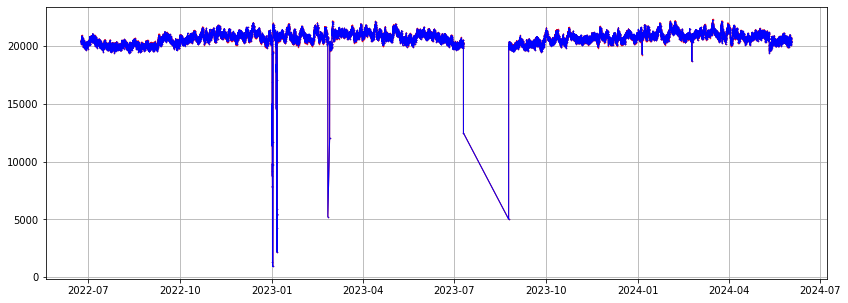

In [28]:
plt.rcParams["axes.grid"] = True
fig, (ax1) = plt.subplots(1,figsize=(14, 5))
#fig.suptitle('Counts')
#ax1.hist(df2_hourly['counts'], bins=100,histtype='step',label='Counts',color='blue')
ax1.plot(merged_df1["ICh23"],
marker='.', markersize=1, linestyle='-', linewidth=1, color='red', label='Counts')
ax1.plot(merged_df1["Ch23"],
marker='.', markersize=1, linestyle='-', linewidth=1, color='blue', label='Ch13')
#ax1.set_title('4 Paddle Counts')
#ax1.set_xlim([pd.Timestamp('2020-11-03'), pd.Timestamp('2021-04-20')])
#ax1.legend();

In [29]:
merged_df1["ICh12_pct"] = ((merged_df1['ICh12'] - merged_df1['ICh12'].mean())/ 
                      merged_df1['ICh12'].mean()*100)
merged_df1["ICh12_m_avg"] = merged_df1.rolling('6H').ICh12_pct.mean()
merged_df1["ICh13_pct"] = ((merged_df1['ICh13'] - merged_df1['ICh13'].mean())/ 
                      merged_df1['ICh13'].mean()*100)
merged_df1["ICh13_m_avg"] = merged_df1.rolling('6H').ICh13_pct.mean()
merged_df1["ICh23_pct"] = ((merged_df1['ICh23'] - merged_df1['ICh23'].mean())/ 
                      merged_df1['ICh23'].mean()*100)
merged_df1["ICh23_m_avg"] = merged_df1.rolling('6H').ICh23_pct.mean()

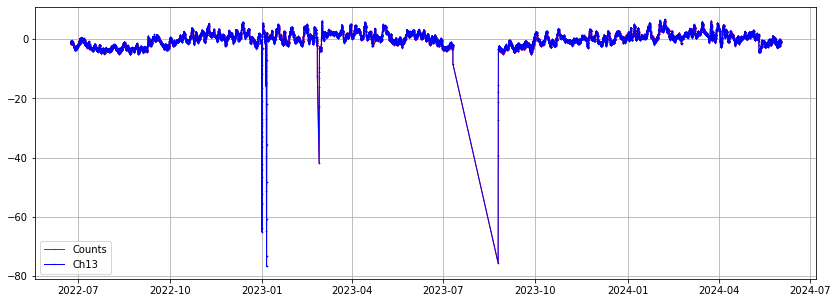

In [33]:
plt.rcParams["axes.grid"] = True
fig, (ax1) = plt.subplots(1,figsize=(14, 5))
#fig.suptitle('Counts')
#ax1.hist(df2_hourly['counts'], bins=100,histtype='step',label='Counts',color='blue')
ax1.plot(merged_df1["Ch23_m_avg"],
marker='.', markersize=1, linestyle='-', linewidth=1, color='red', label='Counts')
ax1.plot(merged_df1["ICh23_m_avg"],
marker='.', markersize=1, linestyle='-', linewidth=1, color='blue', label='Ch13')
#ax1.set_title('4 Paddle Counts')
#ax1.set_xlim([pd.Timestamp('2020-11-03'), pd.Timestamp('2021-04-20')])
ax1.legend();

In [36]:
#title1 = now.year()
#plt.rcParams["axes.grid"] = True
#fig = plt.figure(figsize=(14, 10))
#gs = fig.add_gridspec(3)
#axs = gs.subplots(sharex=False, sharey=False)
#fig.suptitle('Flux %age Change (Muon001 Detector)')
#axs[0].set_title("Last 24 hours (yesterday:now)")
#axs[0].set_title('Last 24 hours:'+str(yesterday)+' to ' +str(now))
#axs[0].plot(merged_df1.loc[yesterday:now, 'ICh12_m_avg'],
#markerfacecolor='white',markeredgecolor="red", marker='.', markersize=4, linestyle='--', linewidth=0.5, color='red', label='#title1 = now.year()')
#plt.rcParams["axes.grid"] = True
#fig = plt.figure(figsize=(14, 10))
#gs = fig.add_gridspec(3)
#axs = gs.subplots(sharex=False, sharey=False)
#fig.suptitle('Flux %age Change (Muon001 Detector)')
#axs[0].set_title("Last 24 hours (yesterday:now)")
#axs[0].set_title('Last 24 hours:'+str(yesterday)+' to ' +str(now))
#axs[0].plot(merged_df1.loc[yesterday:now, 'Icorr_m_avg'],
#markerfacecolor='white',markeredgecolor="red", marker='.', markersize=4, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')

#axs[1].set_title("Last 30 days")
#axs[1].plot(merged_df1.loc[lastmonth:now, 'Icorr_m_avg'],
#markerfacecolor='white',markeredgecolor="red", marker='.', markersize=3, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')
#axs[1].plot(merged_df1_31days['counts_pct'],
#linestyle='--', linewidth=1, color='blue', label='Hourly Counts %')

#axs[2].set_title("All data")
#axs[2].plot(merged_df1["Icorr_m_avg"],
#markerfacecolor='white',markeredgecolor="red", marker='.', markersize=3, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')
#axs[2].plot(merged_df1["counts_m_avg"],
#markerfacecolor='white',markeredgecolor="blue", marker='o', markersize=3, linestyle='', linewidth=0.5, color='blue', label='P-corr counts %')



#axs[2].plot(df1_hourly["Ch23_m_avg"],
#marker='.', markersize=1, linestyle='-', linewidth=1, color='black', label='Ch23_m_avg')

#axs[0].set_ylabel('Flux %age Change')
#axs[0].set_ylim([-15, 15])
#axs[0].legend();
#axs[1].set_ylabel('Flux %age Change')
#axs[1].set_ylim([-20, 20])
#axs[1].legend();
#axs[2].set_ylabel('Flux %age Change')
#axs[2].set_ylim([-20, 20])
#axs[2].legend();
# Hide x labels and tick labels for all but bottom plot.
#for ax in axs:
 #   ax.label_outer()
#plt.savefig('/home/cosmic/onlineMon/images/Colombo_pct_Ch_Pcorr.png')
#axs[0].plot(merged_df1.loc[yesterday:now,"ICh13_m_avg"],
#marker='*', markersize=4, linestyle='', linewidth=0.5, color='green', label="Ch13 %")
#axs[0].plot(merged_df1.loc[yesterday:now,"ICh23_m_avg"],
#marker='v', markersize=4, linestyle='', linewidth=0.5, color='blue', label="Ch23 %")

#axs[1].set_title("Last 30 days")
#axs[1].plot(merged_df1.loc[lastmonth:now, 'ICh12_m_avg'],
#markerfacecolor='white',markeredgecolor="red", marker='.', markersize=3, linestyle='--', linewidth=0.5, color='red', label='Ch12 %')
#axs[1].plot(merged_df1.loc[lastmonth:now,"ICh13_m_avg"],
#marker='*', markersize=3, linestyle='', linewidth=0.5, color='green', label="Ch13 %")
#axs[1].plot(merged_df1.loc[lastmonth:now,"ICh23_m_avg"],
#marker='v', markersize=3, linestyle='', linewidth=0.5, color='blue', label="Ch23 %")
#axs[1].plot(merged_df1_31days['counts_pct'],
#linestyle='--', linewidth=1, color='blue', label='Hourly Counts %')

#axs[2].set_title("All data")
#axs[2].plot(merged_df1["ICh12_m_avg"],
#markerfacecolor='white',markeredgecolor="red", marker='.', markersize=3, linestyle='--', linewidth=0.5, color='red', label='Ch12 %')
#axs[2].plot(merged_df1["ICh13_m_avg"],
#marker='*', markersize=3, linestyle='', linewidth=0.5, color='green', label="Ch13 %")
#axs[2].plot(merged_df1["ICh23_m_avg"],        
#marker='v', markersize=3, linestyle='', linewidth=0.5, color='blue', label="Ch23 %")

#axs[2].plot(df1_hourly["Ch23_m_avg"],
#marker='.', markersize=1, linestyle='-', linewidth=1, color='black', label='Ch23_m_avg')

#axs[0].set_ylabel('Flux %age Change')
#axs[0].set_ylim([-10, 10])
#axs[0].legend();
#axs[1].set_ylabel('Flux %age Change')
#axs[1].set_ylim([-10, 10])
#axs[1].legend();
#[2].set_ylabel('Flux %age Change')
#axs[2].set_ylim([-15, 15])
#axs[2].legend();
# Hide x labels and tick labels for all but bottom plot.
#for ax in axs:
 #   ax.label_outer()
#plt.savefig('/home/cosmic/onlineMon/images/M002_pct_Ch_Pcorr.png')